In [1]:
# %matplotlib notebook
import sys, os
import numpy as np
from datetime import datetime
import itertools

from tqdm import tqdm_notebook, tnrange, tqdm

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D

import ase
from ase.visualize import view
import ase.neighborlist

# from quippy import Atoms as qpAtoms
# import quippy as qp

from sitator.util import PBCCalculator
from sitator.visualization import plot_atoms

from samos.trajectory import Trajectory
from samos.analysis.rdf import RDF
from samos.plotting.plot_rdf import plot_rdf


/mnt/d/Internship/Summer Internship 2025/CPDyAnafork-master/CPDyAnafork-master/sitator-master/sitator/util/progress.py:8: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
from ase import Atoms
T = 500

traj_fname='./data/LLZO-500/trajectory.xyz'
traj_samos='./data/LLZO-500/trajectory.samos'

if os.path.exists(traj_samos):
    t = Trajectory.load_file(traj_samos)
else:
    traj_dict = {
            "cell":[[12.982700,0.0,0.0],[0.0,12.982700,0.0],[0.0,0.0,12.982700]],
            "trajectory_format":"axsf", 'timestep':50.0,
            "species":["La","La","La","La","La","La","La","La",
                "La","La","La","La","La","La","La","La",
                "La","La","La","La","La","La","La","La",
                "Zr","Zr","Zr","Zr","Zr","Zr","Zr","Zr",
                "Zr","Zr","Zr","Zr","Zr","Zr","Zr","Zr",
                "O","O","O","O","O","O","O","O","O","O","O","O","O","O","O","O",
                "O","O","O","O","O","O","O","O","O","O","O","O","O","O","O","O",
                "O","O","O","O","O","O","O","O","O","O","O","O","O","O","O","O",
                "O","O","O","O","O","O","O","O","O","O","O","O","O","O","O","O",
                "O","O","O","O","O","O","O","O","O","O","O","O","O","O","O","O",
                "O","O","O","O","O","O","O","O","O","O","O","O","O","O","O","O",
                "Li","Li","Li","Li","Li","Li","Li","Li",
                "Li","Li","Li","Li","Li","Li","Li","Li",
                "Li","Li","Li","Li","Li","Li","Li","Li",
                "Li","Li","Li","Li","Li","Li","Li","Li",
                "Li","Li","Li","Li","Li","Li","Li","Li",
                "Li","Li","Li","Li","Li","Li","Li","Li",
                "Li","Li","Li","Li","Li","Li","Li","Li"
            ]
        }

    nat = len(traj_dict['species'])
    header_per_frame = 9
    nlines_per_frame = nat + header_per_frame
    positions = list()
    trajectory_format = traj_dict['trajectory_format']
    with open(traj_fname) as ftraj:
        for istep in range(0, traj_dict.get('skip_steps',0)):
            [ftraj.readline() for l in range(nlines_per_frame)]
        while True:
            sth_ = [ftraj.readline() for _ in range(header_per_frame)][-1]
            if not sth_:
                break
            positions_t = np.empty((nat, 3))
            for iat in range(nat):
                line = ftraj.readline().split()
                positions_t[iat, :] = line[0:3]
            positions.append(positions_t)
        atoms = Atoms(traj_dict['species'])
    atoms.set_positions(positions[0])
    atoms.cell = np.array(traj_dict['cell'])
    t = Trajectory()
    t.set_timestep(traj_dict['timestep'])
    t.set_atoms(atoms)
    t.set_positions(np.array(positions))
    t.recenter(['La','Zr','O'])
    t.save(traj_samos)
print("Trajectory length: %i steps (%f ps at dt = %f fs)" % (t.get_positions().shape[0], t.get_positions().shape[0] * t.get_timestep() / 1000.0, t.get_timestep()))


Trajectory length: 200001 steps (10000.050000 ps at dt = 50.000000 fs)


In [3]:
species = np.unique(t.atoms.get_atomic_numbers())
mobile_atomic_number = ase.data.atomic_numbers['Li']
static_species = species[species != mobile_atomic_number]
print("Static species: %s" % ", ".join([ase.data.chemical_symbols[s] for s in static_species]))
li_mask = (t.atoms.get_atomic_numbers() == mobile_atomic_number)
static_mask = np.isin(t.atoms.get_atomic_numbers(), static_species)
static_mask[li_mask] = False

Static species: O, Zr, La


In [4]:
STEPSIZE=10
n = datetime.now()
rdf = RDF(trajectory=t)
rdf_res = rdf.run(radius=5.0,
        species_pairs=[('Li', s) for s in set(t.atoms.get_chemical_symbols())], 
        stepsize=STEPSIZE, istop=None, nbins=200)


(0.0, 15.0)

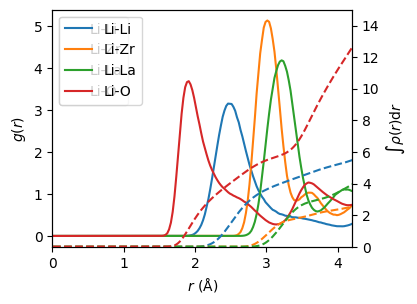

In [5]:
%matplotlib inline
gs = GridSpec(1,1,bottom=0.18, left=0.11, right=0.86, top=0.97)
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(gs[0])
handles = plot_rdf(rdf_res, ax=ax, show=False, )
plt.legend(handles=handles[::2], loc=2)
plt.xlim(0,4.2)
plt.ylim(0,15)


In [6]:
from samos.analysis import dynamics
from samos.plotting.plot_dynamics import plot_msd_isotropic
d = dynamics.DynamicsAnalyzer(trajectories=[t])
msd = d.get_msd(t_start_fit_ps=400, t_end_fit_ps=800, stepsize_tau=100,
                stepsize_t=10, nr_of_blocks=8, species_of_interest=['O'])


    ! Calculating MSD for atomic species O in trajectory 0
      Structure contains 96 atoms of type O
      I will calculate 8 block(s) of size 23000 (1150.0 ps)
      I will fit from 8000 (400.0 ps) to 16000 (800.0 ps)
      Outer stepsize is 10, inner is 100

      Done



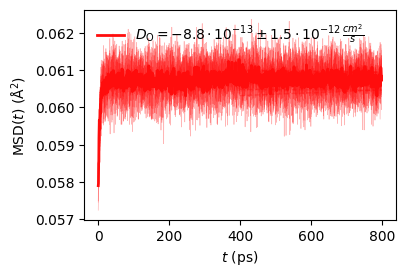

In [7]:
%matplotlib inline
fig = plt.figure(figsize=(4.1,3))
gs = GridSpec(1,1, left=0.2, right=0.96, top=0.9, bottom=0.2)
ax = fig.add_subplot(gs[0])
plot_msd_isotropic(msd, ax=ax, show=False)
plt.show()

In [8]:
# conductivity:
T = 500  # Set temperature in Kelvin (update this value as appropriate)
species, counts = np.unique(t.atoms.get_atomic_numbers(), return_counts=True)
N = dict(zip(species, counts))[3]
V = t.atoms.get_volume() * 1e-30 # m^3
kB = 1.38064852e-23 # m2 kg s-2 K-1
e = 1.60217662e-19 # coulomb
# D = msd.get_attr('Li')['diffusion_mean_cm2_s'] * 1e-4 # m^2/s
D = msd.get_attr('O')['diffusion_mean_cm2_s'] * 1e-4 # m^2/s
H = 1.0  # Haven ratio
sigmaT = H * e**2 * N / V / kB * D * 1e-2 # into 1/m->1/cm
sigma = sigmaT / float(T)
print(sigma, sigmaT)

-8.354559193267449e-08 -4.177279596633725e-05


In [9]:
species = np.unique(t.atoms.get_atomic_numbers())
static_species = species[species != 3]
print("Static species: %s" % ", ".join([ase.data.chemical_symbols[s] for s in static_species]))
li_mask = (t.atoms.get_atomic_numbers() == 3)
static_mask = np.isin(t.atoms.get_atomic_numbers(), static_species)
static_mask[li_mask] = False

Static species: O, Zr, La


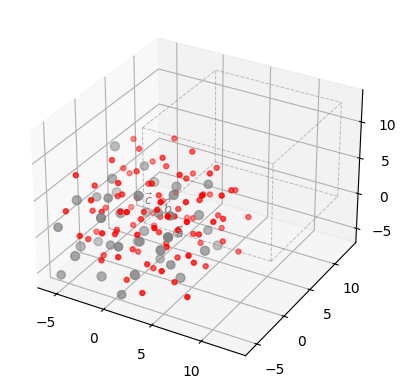

In [10]:
starting_positions = t.get_positions()[0]

pbccalc = PBCCalculator(t.atoms.cell)

avg_positions = pbccalc.time_average(t.get_positions())
t.atoms.set_positions(avg_positions)
ax = plot_atoms(t.atoms[static_mask], positions = t.get_positions()[3][static_mask])

In [ ]:
from sitator.landmark import LandmarkAnalysis
from sitator.voronoi import VoronoiSiteGenerator
from sitator import SiteNetwork, SiteTrajectory

landmark_stride = 100

positions = t.get_positions()

print("Will compute landmark vectors every %.1f fs (%i frames)." % (landmark_stride * t.get_timestep(), landmark_stride)) 
sn = SiteNetwork(t.atoms, static_mask, li_mask)

voronoi = VoronoiSiteGenerator(zeopp_path="/mnt/d/Downloads/zeo++-0.3/network")
sn_voro = voronoi.run(sn)

la = LandmarkAnalysis(
                      cutoff_midpoint=1.8, #1.3 originally
                      cutoff_steepness=30,
                      minimum_site_occupancy = 0.05, # Minimum occupancy for a site to be considered as such
                      check_for_zero_landmarks=True, 
                      clustering_algorithm = 'dotprod',
                      clustering_params = {
                          'clustering_threshold' : 0.9, # Aggressivly granular clustering
                          'assignment_threshold' : 0.85
                      },
                      peak_evening = 'none',
                      static_movement_threshold = 5.0, # How stringent the analysis should be.
                      dynamic_lattice_mapping = True,  # |
                      relaxed_lattice_checks = True,  # | False originally
                      max_mobile_per_site=2)  

la_results = la.run(sn_voro, t.get_positions()[::landmark_stride])

Will compute landmark vectors every 5000.0 fs (100 frames).


Landmark Frame:   0%|                                                                                                                       | 0/2001 [00:00<?, ?it/s]Static atom 77 is the closest to more than one static lattice position
Static atom 124 is the closest to more than one static lattice position
Static atom 16 is the closest to more than one static lattice position
Static atom 6 is the closest to more than one static lattice position
Static atom 61 is the closest to more than one static lattice position
Static atom 73 is the closest to more than one static lattice position
Static atom 55 is the closest to more than one static lattice position
Static atom 73 is the closest to more than one static lattice position
Static atom 42 is the closest to more than one static lattice position
Static atom 88 is the closest to more than one static lattice position
Static atom 49 is the closest to more than one static lattice position
Static atom 52 is the closest to more than one static 

8
1.0000781265259087
782
(2001, 56)
0.08611765545798529
250


/mnt/d/Internship/Summer Internship 2025/CPDyAnafork-master/CPDyAnafork-master/sitator-master/sitator/visualization/atoms.py:77: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(pts[:,0], pts[:,1], pts[:,2],


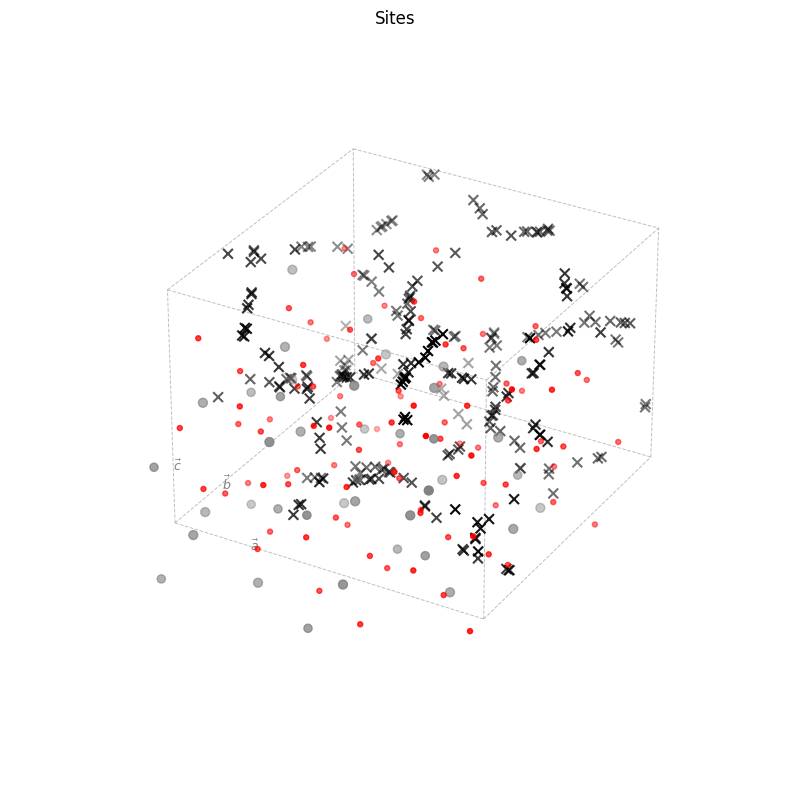

In [12]:
print(la.n_multiple_assignments) # Number of frames when more than one mobile atom was assigned to one site
print(la.avg_mobile_per_site)
print(la.landmark_dimension)
print(la_results.traj.shape)
print(la_results.percent_unassigned)
print(la_results.site_network.n_sites)
from sitator.visualization.atoms import plot_atoms, plot_points
from sitator.visualization.common import layers, grid
la_results.site_network.plot()

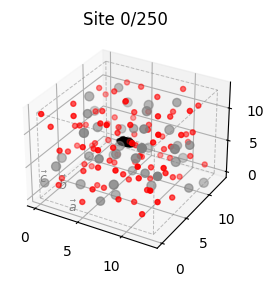

In [13]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111, projection = '3d')
la_results.plot_site(0, fig=fig, ax=ax) # Shows all real-space positions that were assigned to this site.

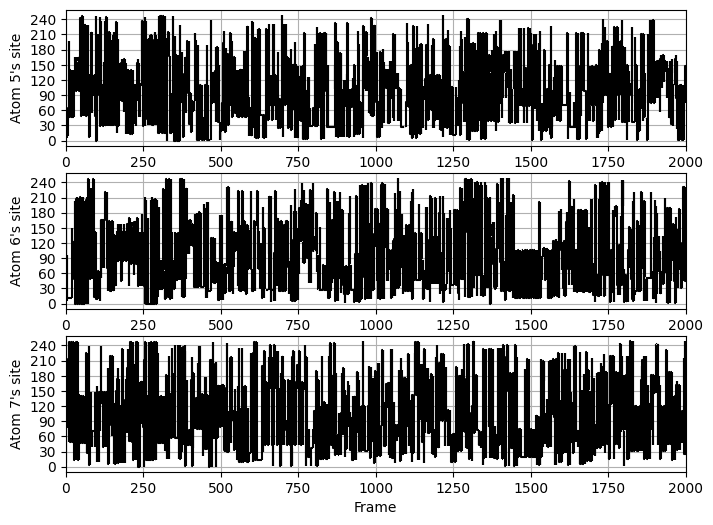

In [14]:
f = grid(*[[(la_results.plot_particle_trajectory, {'particle' : i})] for i in range(5, 8)], 
         is3D=False, sharex=True)

In [15]:
from sitator import dynamics
print('before', la_results.site_network.n_sites)
msbd = dynamics.MergeSitesByDynamics(check_types=False, distance_threshold=1.7, #1.5 original 
                                     markov_parameters={'inflation':100, 'expansion':2})
msbd_res = msbd.run(la_results)

  This may or may not be a problem; but if `distance_threshold` is low, consider raising it.


before 250


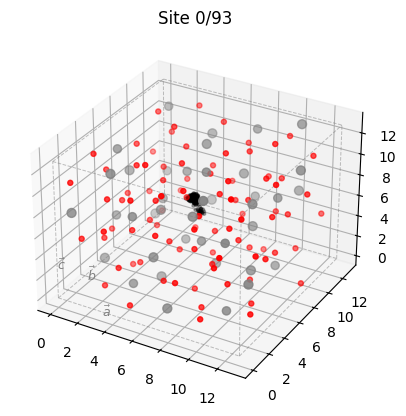

In [16]:
# msbd_res.site_network.plot()
msbd_res.plot_site(0)

(1000.0, 3000.0)

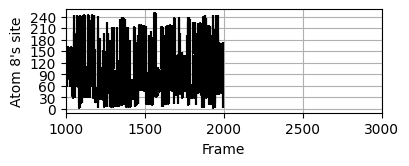

In [17]:
pindex = 8
gs = GridSpec(1,1, bottom=0.3, left=0.15, top=0.99, right=0.94)
fig = plt.figure(figsize=(4,1.5))
ax = fig.add_subplot(gs[0])
la_results.plot_particle_trajectory(pindex, fig=fig, ax=ax)
plt.xlim(1000, 3000)
# plt.savefig('site-trajectory-LLZO-{}.pdf'.format(pindex))

In [99]:
# from sitator.site_descriptors import SiteTypeAnalysis, SOAP
# desc = SOAP.SOAPDescriptorAverages(tracer_atomic_number=3, environment=['O'], soap_params={
#     'atom_sigma':0.7,'cutoff':3.5,'n_max':6, 'l_max':6, 'cutoff_transition_width':0.5}, 
#     stepsize=50, averaging=5, soap_mask=t.atoms.get_atomic_numbers()==8)
# sta = SiteTypeAnalysis(desc, min_pca_variance=0.9, n_site_types_max=20)
# sta_res = sta.run(msbd_res)
# # sta_res = sta.run(la_results)
import sitator.site_descriptors as sd
from sitator.site_descriptors.SOAP import SOAPDescriptorAverages
from sitator.site_descriptors.backend.dscribe_sitator import dscribe_soap_backend

# Ensure msbd_res is defined
try:
    msbd_res
except NameError:
    raise RuntimeError("msbd_res is not defined. Please run the cell that defines msbd_res before running this cell.")

# all_species = np.unique(msbd_res.site_network.static_structure.get_atomic_numbers())
# soap_mask = msbd_res.site_network.static_mask & (msbd_res.site_network.structure.get_atomic_numbers() == 8)
soap_mask=t.atoms.get_atomic_numbers()==8
# print("All species for SOAP:", all_species)  # Should print [3, 8, 40, 57]

soap_params = {
    'sigma': 0.7,
    'r_cut': 3.5,
    'n_max': 6,
    'l_max': 6,
    'cutoff_transition_width': 0.5,
    'periodic': True,
    'rbf': 'gto',
    # 'species': all_species.tolist()  # Ensure species is a list
}

# Create the backend with your parameters
backend = dscribe_soap_backend(soap_params=soap_params)
print("Backend type:", type(backend))
print("Backend:", backend)

# Pass the backend to SOAPDescriptorAverages
desc = SOAPDescriptorAverages(
    tracer_atomic_number=3,
    environment=['O'],
    # environment=['O', 'Zr', 'La'],  # Include all relevant species
    stepsize=50,
    averaging=5,
    backend=backend,
    soap_mask=soap_mask  # Use the mask for SOAP
)
desc.get_descriptors(msbd_res)
sta = sd.SiteTypeAnalysis(desc, min_pca_variance=0.9, n_site_types_max=18) #n_site_types_max=20 originally
sta_res = sta.run(msbd_res)

Backend type: <class 'function'>
Backend: <function dscribe_soap_backend.<locals>.backend at 0x7faedd4c34c0>


SOAP Frame: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 594.81it/s]


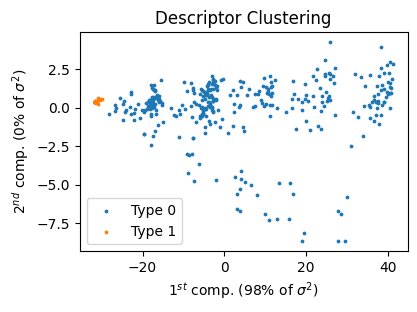

In [100]:
%matplotlib inline
fig = plt.figure(figsize=(4,3))
gs = GridSpec(1,1, hspace=0.45, right=0.99, left=0.17, top=0.9, bottom=0.17)
ax1 = fig.add_subplot(gs[0])
#ax2 = fig.add_subplot(gs[1])
#sta.plot_dvecs(fig=fig, ax=ax1)
sta.plot_clustering(fig=fig, ax=ax1)
plt.show()
#plt.savefig('LLZO-{}-SOAP-clustering.pdf'.format(T))

In [101]:

from sitator import dynamics

sta_st = msbd_res[:]
#sta_st = la_results[:]
sta_st.site_network = sta_res
for k in ('occupancies', 'jump_lag','n_ij','p_ij', 'residence_times', 'occupancy_freqs',
         'total_corrected_residences'):
    if sta_st.site_network.has_attribute(k):
        sta_st.site_network.remove_attribute(k)

sta_st.compute_site_occupancies()
ja3 = dynamics.JumpAnalysis()

ja3.run(sta_st)

/mnt/d/Internship/Summer Internship 2025/CPDyAnafork-master/CPDyAnafork-master/sitator-master/sitator/dynamics/JumpAnalysis.py:220: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(lbls)
/mnt/d/Internship/Summer Internship 2025/CPDyAnafork-master/CPDyAnafork-master/sitator-master/sitator/dynamics/JumpAnalysis.py:221: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(lbls)


Text(0.5, 1.0, '')

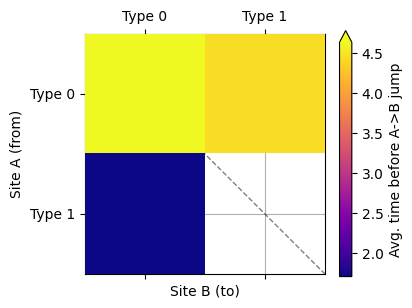

In [102]:
fig = plt.figure(figsize=(4,3))
gs = GridSpec(1,1, top=0.9, left=0.2, right=0.95, bottom=0.08)
ax = fig.add_subplot(gs[0])

ja3.plot_jump_lag(sta_st.site_network, mode='type',min_n_events=10, fig=fig, ax=ax)
ax.set_title("")
# plt.savefig("LLZO-jump-lag-by-type.pdf")

In [103]:
import sitator.network.DiffusionPathwayAnalysis

if sta_st.site_network.has_attribute('site_diffusion_pathway'):
    sta_st.site_network.remove_attribute('site_diffusion_pathway')
    sta_st.site_network.remove_attribute('edge_diffusion_pathway')

dpa = sitator.network.DiffusionPathwayAnalysis(
    connectivity_threshold=1, minimum_n_sites = 5)
dpa.run(sta_st.site_network)

(<sitator.SiteNetwork.SiteNetwork at 0x7faf1501e8e0>,)

[]

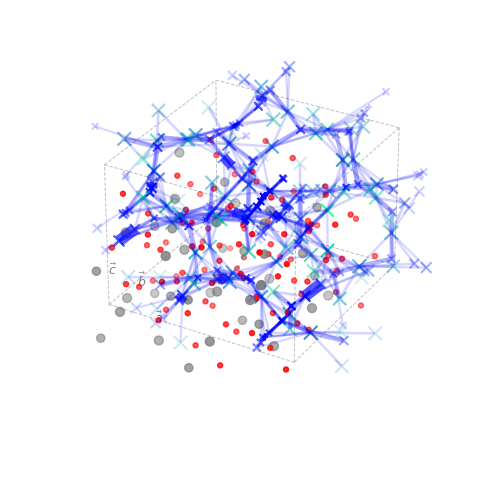

In [104]:
%matplotlib inline

from sitator.visualization import SiteNetworkPlotter; 

snp = SiteNetworkPlotter(site_mappings={'color' : 'residence_times', 'size' : 'occupancies', 'marker' : 'site_types'},
                         edge_mappings={'intensity' : 'p_ij', 'width' : 'n_ij', 'group' : 'edge_diffusion_pathway'},
                         min_width_threshold = 0.005,
                         min_color_threshold = 0.005)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
f = snp(sta_st.site_network, fig=fig, ax=ax)
ax.set_yticks([])
ax.set_xticks([])
ax.set_zticks([])
#plt.savefig('analysis-llzo.png', dpi=600)

In [105]:
%matplotlib inline
from samos.analysis.rdf import RDF
from samos.plotting.plot_rdf import plot_rdf
from ase import Atom
from matplotlib.gridspec import GridSpec

site_trajectory =  msbd_res.traj
static_m = np.where(msbd_res.site_network.static_mask)[0]
mobile_m = np.where(msbd_res.site_network.mobile_mask)[0]

len_static_m = len(static_m)
newatoms = msbd_res.site_network.static_structure.copy()

newatoms.append(Atom('Li', (0.,0.,0.)))

positions_type =  [[] for _ in range(len(np.unique(sta_res.site_types)))]

site_indices = range(site_trajectory.max()+1)

for i1, site_idx in enumerate(site_indices):
    timesteps, indices = np.where(site_trajectory == site_idx)
    traj_this_site = np.zeros((len(timesteps), len_static_m+1 ,3))
    for t_idx, (timestep, li_index) in enumerate(zip(timesteps, indices)):
        try:
            traj_this_site[t_idx, :len_static_m, :] =  msbd_res._real_traj[timestep, static_m, :]
            traj_this_site[t_idx, len_static_m, :] = msbd_res._real_traj[timestep, mobile_m[li_index], :]
        except IndexError:
            break
    positions_type[sta_res.site_types[site_idx]].append(traj_this_site)

In [106]:
rdf_results = []
trajectories_type = []
for idx, positions_this_type in enumerate(positions_type):
    newt = Trajectory(atoms=newatoms)
    newt.set_positions(np.concatenate(positions_this_type, axis=0))
    trajectories_type.append(newt)
    rdf = RDF(trajectory=newt)
    rdf_results.append(rdf.run(radius=5.,
             species_pairs=(['Li', 'O'], ), #,['Li', 'Zr'],['Li', 'La'], ),
             stepsize=10, istop=None, nbins=80))


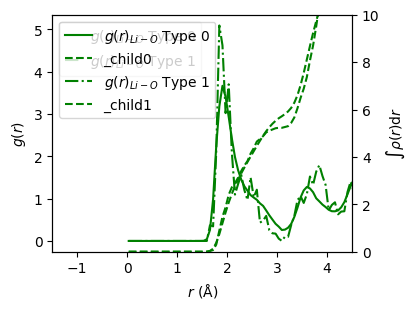

In [107]:
%matplotlib inline
fig = plt.figure(figsize=(4,3))
gs = GridSpec(1,1, left=0.11, right=0.86, top=0.97, bottom=0.18)
ax = fig.add_subplot(gs[0])
ax2 = ax.twinx()
colors = ['r', 'g', 'b', 'black']
# for i, rdf_res in enumerate(rdf_results[:2]):
handles = []
linestyles = ['-', '-.', ':']
colordict = {'Li_O':'g', 'Li_Zr':'r', 'Li_La':'b'}
for i in range(len(rdf_results)):
    handles += plot_rdf(
        rdf_results[i], ax=ax, ax2=ax2, show=False,
        plot_params=dict(
            colordict=colordict,
            linestyle=linestyles[i % len(linestyles)],
            labelspec='Type {}'.format(i)
        ),
        plot_params2=dict(label=None)
    )

ax2.set_ylim(0,10)
ax.set_xlim(-1.5,4.5)
plt.legend(handles=handles, loc=2)
# plt.legend(handles=handles1+handles2,loc=1)